# Sudoku Solver AI
Using CNNs

## Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from model_utility import sudoku_as_images, shuffle_together
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Reshape, Flatten, Concatenate

## Constants

In [2]:
DATA_POINTS = 100_000
BATCH_SIZE = 128
EPOCHS = 100
RANDOM_STATE = 7
LEARNING_RATE = 0.0005
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 0.85, 0.1, 0.05
FILTERS_FULL, FILTERS_BLOCK, FILTERS_ROW, FILTERS_COLUMN = 27, 81, 81, 81

## Loading Data

In [3]:
df = pd.read_csv("..\..\Datasets\Sudoku Puzzles\sudoku.csv", nrows = DATA_POINTS)
df.head()

,puzzle,solution
0,0700000430400096108006349000940520003584600200...,6795182435437296188216349577943521863584617292...
1,3010865040465210705000000014008000020803479000...,3719865248465213795924738614638197522853479167...
2,0483015603600080909106700030200009355090102006...,7483915623652487919126754834217869355894132766...
3,0083170000042051090000400703271609049014500000...,2983176457642851391539462783271689549814537266...
4,0408906300001368208007405190004670524500207002...,1428956379751368248367425193984671524513287962...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   puzzle    100000 non-null  object
 1   solution  100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


## Data preprocessing

### Refactoring data to 9 X 9 numpy arrays

In [5]:
puzzles = np.array(list(map(list, df['puzzle'].values))).reshape(-1, 9, 9, 1).astype(int)
puzzles[0]

array([[[0],
        [7],
        [0],
        [0],
        [0],
        [0],
        [0],
        [4],
        [3]],

       [[0],
        [4],
        [0],
        [0],
        [0],
        [9],
        [6],
        [1],
        [0]],

       [[8],
        [0],
        [0],
        [6],
        [3],
        [4],
        [9],
        [0],
        [0]],

       [[0],
        [9],
        [4],
        [0],
        [5],
        [2],
        [0],
        [0],
        [0]],

       [[3],
        [5],
        [8],
        [4],
        [6],
        [0],
        [0],
        [2],
        [0]],

       [[0],
        [0],
        [0],
        [8],
        [0],
        [0],
        [5],
        [3],
        [0]],

       [[0],
        [8],
        [0],
        [0],
        [7],
        [0],
        [0],
        [9],
        [1]],

       [[9],
        [0],
        [2],
        [1],
        [0],
        [0],
        [0],
        [0],
        [5]],

       [[0],
        [0],
        [7],
        [

In [6]:
solutions = np.array(list(map(list, df['solution'].values))).reshape(-1, 9, 9, 1).astype(int)
solutions[0]

array([[[6],
        [7],
        [9],
        [5],
        [1],
        [8],
        [2],
        [4],
        [3]],

       [[5],
        [4],
        [3],
        [7],
        [2],
        [9],
        [6],
        [1],
        [8]],

       [[8],
        [2],
        [1],
        [6],
        [3],
        [4],
        [9],
        [5],
        [7]],

       [[7],
        [9],
        [4],
        [3],
        [5],
        [2],
        [1],
        [8],
        [6]],

       [[3],
        [5],
        [8],
        [4],
        [6],
        [1],
        [7],
        [2],
        [9]],

       [[2],
        [1],
        [6],
        [8],
        [9],
        [7],
        [5],
        [3],
        [4]],

       [[4],
        [8],
        [5],
        [2],
        [7],
        [6],
        [3],
        [9],
        [1]],

       [[9],
        [6],
        [2],
        [1],
        [8],
        [3],
        [4],
        [7],
        [5]],

       [[1],
        [3],
        [7],
        [

### Normalising the data

In [7]:
puzzles = puzzles/9
puzzles[0]

array([[[0.        ],
        [0.77777778],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.44444444],
        [0.33333333]],

       [[0.        ],
        [0.44444444],
        [0.        ],
        [0.        ],
        [0.        ],
        [1.        ],
        [0.66666667],
        [0.11111111],
        [0.        ]],

       [[0.88888889],
        [0.        ],
        [0.        ],
        [0.66666667],
        [0.33333333],
        [0.44444444],
        [1.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [1.        ],
        [0.44444444],
        [0.        ],
        [0.55555556],
        [0.22222222],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.33333333],
        [0.55555556],
        [0.88888889],
        [0.44444444],
        [0.66666667],
        [0.        ],
        [0.        ],
        [0.22222222],
        [0.        ]],



In [8]:
solutions = solutions/9
solutions[0]

array([[[0.66666667],
        [0.77777778],
        [1.        ],
        [0.55555556],
        [0.11111111],
        [0.88888889],
        [0.22222222],
        [0.44444444],
        [0.33333333]],

       [[0.55555556],
        [0.44444444],
        [0.33333333],
        [0.77777778],
        [0.22222222],
        [1.        ],
        [0.66666667],
        [0.11111111],
        [0.88888889]],

       [[0.88888889],
        [0.22222222],
        [0.11111111],
        [0.66666667],
        [0.33333333],
        [0.44444444],
        [1.        ],
        [0.55555556],
        [0.77777778]],

       [[0.77777778],
        [1.        ],
        [0.44444444],
        [0.33333333],
        [0.55555556],
        [0.22222222],
        [0.11111111],
        [0.88888889],
        [0.66666667]],

       [[0.33333333],
        [0.55555556],
        [0.88888889],
        [0.44444444],
        [0.66666667],
        [0.11111111],
        [0.77777778],
        [0.22222222],
        [1.        ]],



## Cleanup
Deleting variables no more required to clear memory

In [9]:
del df

## Data Visualization

Since the data is in square arrays with values between 0 and 1, they can be easily visualised as images.

The pure black sections in the images of the puzzles denote the cells which need to be filled.

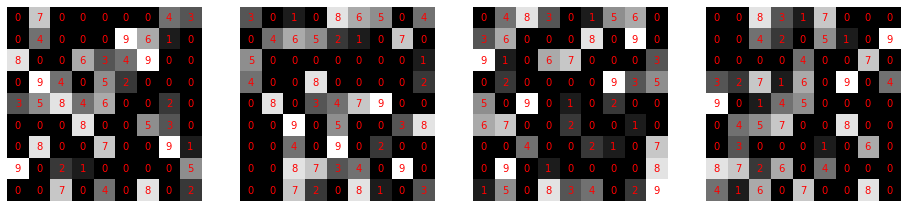

In [10]:
sudoku_as_images(puzzles[:4])

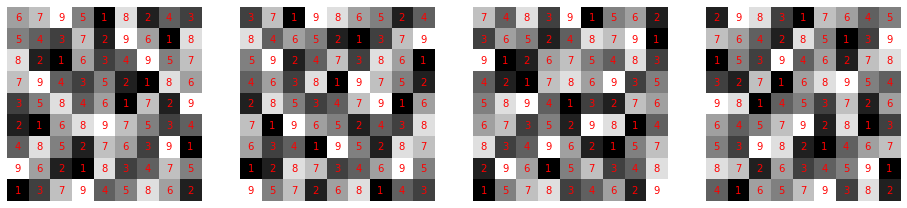

In [11]:
sudoku_as_images(solutions[:4])

## Train, Validation and Test data preparation

### Shuffle the inputs and outputs in place

In [12]:
shuffle_together([puzzles, solutions], RANDOM_STATE)

### Training Data

In [13]:
X_train = puzzles[: int(DATA_POINTS * TRAIN_SIZE)]
y_train = solutions[: int(DATA_POINTS * TRAIN_SIZE)]

print("Training data:")
print(f"Input shape - {X_train.shape}")
print(f"Output shape - {y_train.shape}")

Training data:
Input shape - (85000, 9, 9, 1)
Output shape - (85000, 9, 9, 1)


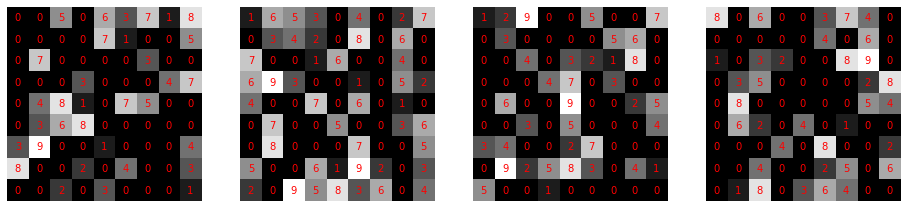

In [14]:
sudoku_as_images(X_train[:4])

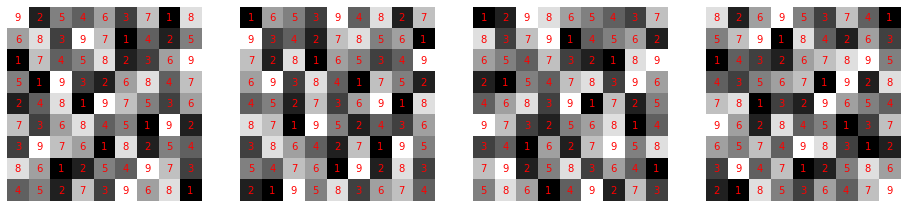

In [15]:
sudoku_as_images(y_train[:4])

### Validation Data

In [16]:
val_data_range = range(int(DATA_POINTS * TRAIN_SIZE), int(DATA_POINTS * (TRAIN_SIZE + VAL_SIZE)))

X_val = puzzles[val_data_range]
y_val = solutions[val_data_range]

print("Validation data:")
print(f"Input shape - {X_val.shape}")
print(f"Output shape - {y_val.shape}")

Validation data:
Input shape - (10000, 9, 9, 1)
Output shape - (10000, 9, 9, 1)


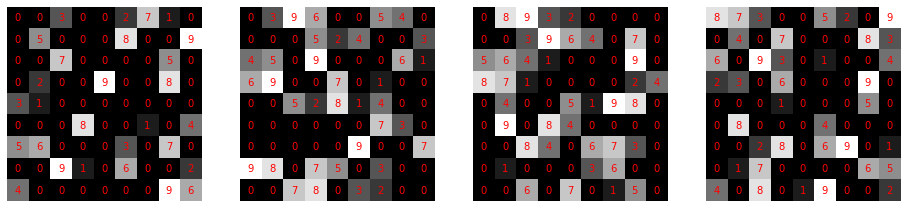

In [17]:
sudoku_as_images(X_val[:4])

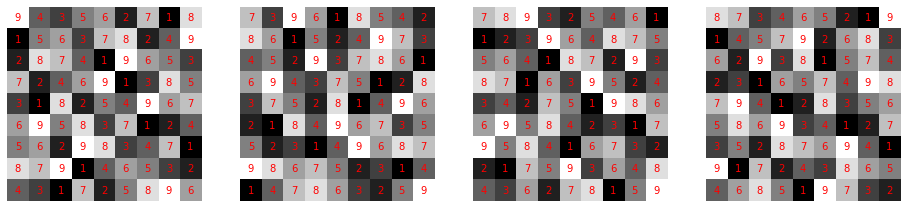

In [18]:
sudoku_as_images(y_val[:4])

### Testing Data

In [19]:
X_test = puzzles[int(DATA_POINTS * (TRAIN_SIZE + VAL_SIZE)):]
y_test = solutions[int(DATA_POINTS * (TRAIN_SIZE + VAL_SIZE)):]

print("Training data:")
print(f"Input shape - {X_test.shape}")
print(f"Output shape - {y_test.shape}")

Training data:
Input shape - (5000, 9, 9, 1)
Output shape - (5000, 9, 9, 1)


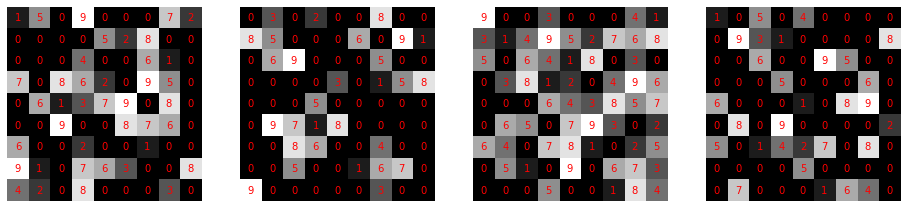

In [20]:
sudoku_as_images(X_test[:4])

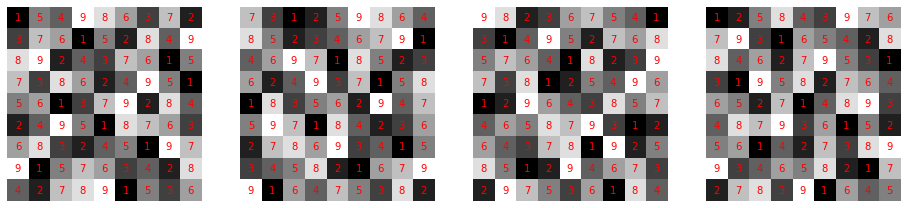

In [21]:
sudoku_as_images(y_test[:4])

## Model

In [22]:
inputs = tf.keras.Input(shape = (9, 9, 1))
inputs.shape

TensorShape([None, 9, 9, 1])

In [23]:
full_conv = Conv2D(FILTERS_FULL, 1)(inputs)
full_conv.shape

TensorShape([None, 9, 9, 27])

In [24]:
full_flatten = Flatten()(full_conv)
full_flatten.shape

TensorShape([None, 2187])

In [25]:
block_conv = Conv2D(FILTERS_BLOCK, 3, strides = 3)(inputs)
block_conv.shape

TensorShape([None, 3, 3, 81])

In [26]:
block_flatten = Flatten()(block_conv)
block_flatten.shape

TensorShape([None, 729])

In [27]:
row_conv = Conv2D(FILTERS_ROW, (1, 9))(inputs)
row_conv.shape

TensorShape([None, 9, 1, 81])

In [28]:
row_flatten = Flatten()(row_conv)
row_flatten.shape

TensorShape([None, 729])

In [29]:
column_conv = Conv2D(FILTERS_COLUMN, (9, 1))(inputs)
column_conv.shape

TensorShape([None, 1, 9, 81])

In [30]:
column_flatten = Flatten()(column_conv)
column_flatten.shape

TensorShape([None, 729])

In [31]:
concatenated = Concatenate()([full_flatten, block_flatten, row_flatten, column_flatten])
concatenated.shape

TensorShape([None, 4374])

In [32]:
dropout_1 = Dropout(0.3)(concatenated)
dropout_1.shape

TensorShape([None, 4374])

In [33]:
dense_1 = Dense(1024, activation='relu')(dropout_1)
dense_1.shape

TensorShape([None, 1024])

In [34]:
dropout_2 = Dropout(0.2)(dense_1)
dropout_2.shape

TensorShape([None, 1024])

In [35]:
dense_2 = Dense(81, activation = 'sigmoid')(dropout_2)
dense_2.shape

TensorShape([None, 81])

In [36]:
reshaped_output = Reshape((9, 9, 1))(dense_2)
reshaped_output.shape

TensorShape([None, 9, 9, 1])

In [37]:
model = tf.keras.Model(inputs = inputs, outputs = reshaped_output, name = "Sudoku_CNN")
model.summary()

Model: "Sudoku_CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 9, 1)]    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 9, 9, 27)     54          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 3, 81)     810         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 9, 1, 81)     810         input_1[0][0]                    
_________________________________________________________________________________________

In [38]:
model.compile(
    loss = 'mse',
    optimizer = Adam(LEARNING_RATE)
)

## Training

In [39]:
%%time

history = model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, y_val))

Epoch 1/100
665/665 [==============================] - 5s 7ms/step - loss: 0.0671 - val_loss: 0.0627
Epoch 2/100
665/665 [==============================] - 4s 7ms/step - loss: 0.0568 - val_loss: 0.0508
Epoch 3/100
665/665 [==============================] - 4s 6ms/step - loss: 0.0524 - val_loss: 0.0502
Epoch 4/100
665/665 [==============================] - 4s 7ms/step - loss: 0.0517 - val_loss: 0.0499
Epoch 5/100
665/665 [==============================] - 4s 6ms/step - loss: 0.0513 - val_loss: 0.0494
Epoch 6/100
665/665 [==============================] - 5s 7ms/step - loss: 0.0509 - val_loss: 0.0490
Epoch 7/100
665/665 [==============================] - 4s 6ms/step - loss: 0.0504 - val_loss: 0.0485
Epoch 8/100
665/665 [==============================] - 4s 6ms/step - loss: 0.0500 - val_loss: 0.0479
Epoch 9/100
665/665 [==============================] - 4s 6ms/step - loss: 0.0496 - val_loss: 0.0473
Epoch 10/100
665/665 [==============================] - 4s 6ms/step - loss: 0.0491 - val_lo

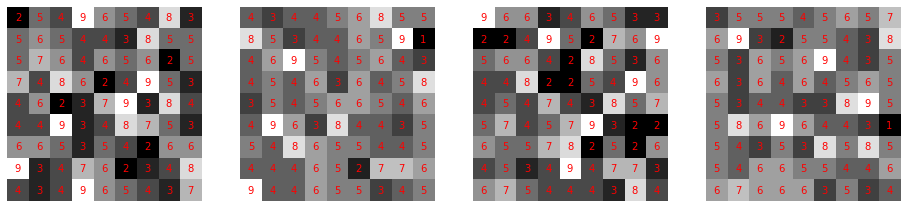

In [40]:
pred = model.predict(X_test[:4])
sudoku_as_images((((pred * 9) + 0.5).astype(int)/9))

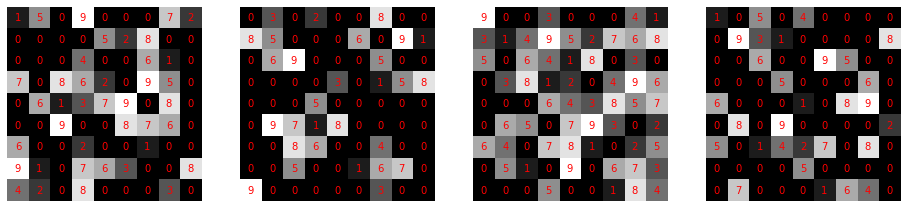

In [41]:
sudoku_as_images(X_test[:4])

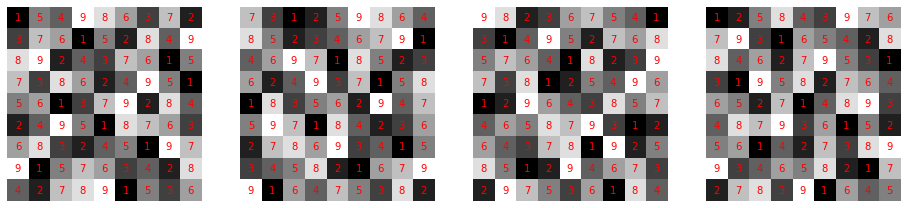

In [42]:
sudoku_as_images(y_test[:4])